### Group Members:

- Giovanni Sergio Armido Parri, 16-919-144

# Assignment 10: Predict Stock Price

In this assignment we will construct a simple recurrent network with a single hidden layer: a long short-term memory network (LSTM).
This network will be trained on historical stock market datasets of two distinct companies, and our objective is to leverage them for predicting their future stock prices.

Given that our dataset is non-textual, we will skip any text-based data transformations during the network training process, focusing only on normalization of the data.
Basically, the dataset comprises the daily closing prices of a stock in the market spanning from early 2000 to 2021.
Since we will be working with a single time series feature, it is important to select the appropriate dimension $D$ to represent the stock price at each time step.

Price sequences of length $S$ will, hence, be turned into matrices of size $\mathbf X = \{\vec x^{\{s\}}, 1 \leq s\leq S\} \in \mathbb R^{S\times D}$.
For each input, you should provide the target value $\mathbf T$ based on a sequence length $S$, where the target for each sample corresponds to the price of the next time step: $\vec t^{\{s\}} = \vec x ^{\{s+1\}}$.

To speed up processing, these sequences will be put into batches, i.e., $\mathcal X \in \mathbb R^{B\times S\times D}$ and $\mathcal T \in \mathbb R^{B\times D}$.
This will automatically be achieved using the default PyTorch `DataLoader`.

The datasets that we will use are provided here:

GAIL stock: https://raw.githubusercontent.com/Pranavd0828/NIFTY50-StockMarket/main/Dataset/GAIL.csv

NTPC stock: https://raw.githubusercontent.com/Pranavd0828/NIFTY50-StockMarket/main/Dataset/NTPC.csv


## Data and Targets Preprocessing


Initially, we will load the datasets for GAIL and NTPC, selecting only the "Date" and "Close" features to be able to obtain $\mathbf X$ and $\mathbf T$. 
Then, we will normalize the value of prices since neural networks are sensitive to the scale of input features.
Finally, we will reserve data from '2018-01-01' onwards from both datasets for testing purposes, where our objective is to predict future stock prices.

For a given index $n$ into our data and a given sequence length $S$, we provide the input $\mathbf X ^{[n]}$ and the target $\mathbf T^{[n]}$ as follows:

  $$\mathbf X^{[n]} = \{ \vec x[t] \ | \ n \leq t < n+S \ | \ 0 \leq n < N-S \}$$
  $$\mathbf T^{[n]} = \vec x[n+S] $$

where $\mathbf N$ is the length of the data. 


For example, for the original data $[10,20,30,40,50,30,40,25,60,70,...]$, sequence length $S=5$ and index $n=2$, we would have the representations for $x = $ `[30,40,50,30,40]` and $t=$ `25`.

Finally, we implement our own `Dataset` that returns the input and target.

### Download the data file

Please run the code block below to download the data file.

In [6]:
import os
import urllib.request
import torch
import numpy

# URLs for GAIL and NTPC stock CSV files
urls = [
    "https://raw.githubusercontent.com/Pranavd0828/NIFTY50-StockMarket/main/Dataset/GAIL.csv",
    "https://raw.githubusercontent.com/Pranavd0828/NIFTY50-StockMarket/main/Dataset/NTPC.csv"
]
for url in urls:
  filename = url.split("/")[-1]

  if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)
    print ("Downloaded datafile: ", filename)

Downloaded datafile:  GAIL.csv
Downloaded datafile:  NTPC.csv


### Task 1: Data Loading

Implement a function that:
1. Loads/read all data from the .csv files `GAIL.csv` and `NTPC.csv` 
2. Choose only the `Date` and `Close` features to retrieve the date and price variables
3. The `date` variable should be returned as a 1D NumPy array with the data type `numpy.datetime64()`
4. The `price`  price should be returned as a 1D `Torch.Tensor`.

Note:

* Please make sure that you convert each date to specified dtype above.


In [7]:
import pandas

# load all data from the text file
def get_data(datafile):

    # Read/open datafile CSV file into a pandas DataFrame
    data = pandas.read_csv(datafile)

    # Extract date and convert to numpy array
    date = numpy.array(data['Date'])

    # Extract closing prices and convert to torch Tensor
    price = torch.tensor(data['Close'])

    return date, price

In [59]:
# read each datafile
gail_data = get_data('GAIL.csv')
ntpc_data = get_data("NTPC.csv")



2018-01-01
4162


### Task 2: Train Test Split

Implement a function that splits the entire dataset into training and test sets:

1. This function takes a tuple containing dates and corresponding prices as input.
2. Prices corresponding to dates before `2018-01-01` should be allocated to the training set, while prices from `2018-01-01` onwards should be assigned to the test set.
3. The function returns two tensors: one for the training prices and another for the test prices based on the split criteria.

In [61]:
def train_test_split(stock_data):

    idx = numpy.where(stock_data[0] == '2018-01-01')[0][0] + 1
    train_data = stock_data[1][:idx] #this number has been found by trials
    test_data = stock_data[1][idx:]

    return train_data, test_data

# split the datas for both dataset
gail_train,gail_test = train_test_split(gail_data)
ntpc_train,ntpc_test = train_test_split(ntpc_data)

### Task 3: Data Normalization (Min Max Scaler) 

Implement two functions: one for scaling data, and the other for reversing this scaling.

1. Scaling function will normalize the data with correct statistics `min` and `max`.
2. Reverse scaling function will convert the scaled data back to its original scale 
3. With `min` and `max`, here is the formula for the scaling process:

    $$X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$$
4. Normalize train and test sets of both datasets.

Note:

* When returning to the original values, ensure that you use the correct minimum and maximum values.

In [62]:
def min_max_scaler(train_data, test_data):

    # Compute the correct statistics
    min_val = torch.min(train_data)
    max_val = torch.max(train_data)

    # Scale the training data
    train_data_scaled = (train_data-min_val)/(max_val-min_val)

    # Scale the test data using the same min and max values
    test_data_scaled = (test_data-min_val)/(max_val-min_val)

    return train_data_scaled, test_data_scaled, min_val, max_val


def inverse_min_max_scaler(scaled_data, min_val, max_val):

    # Revert the scaling
    original_data = scaled_data*(max_val-min_val)+min_val

    return original_data

# scale the data for both datasets
train_gail_scaled,test_gail_scaled,min_gail,max_gail = min_max_scaler(gail_train,gail_test)
train_ntpc_scaled,test_ntpc_scaled,min_ntpc,max_ntpc = min_max_scaler(ntpc_train,ntpc_test)

### Test 1: Scaling
This test ensures that both scaling and its inverse operation are implemented correctly.

In [63]:
random_train_data = torch.ones(50)*20.
random_train_data[:15] = -10.
random_train_data[15:25] = 5.

random_test_data = torch.ones(30)*25

# scaling
scaled_train_data,scaled_test_data,min_val,max_val = min_max_scaler(random_train_data,random_test_data)
assert torch.sum(scaled_train_data) - 30 < 1e-5
assert torch.sum(scaled_test_data) - 35 < 1e-5

# reverse scaling
reversed_train_data = inverse_min_max_scaler(scaled_train_data,min_val,max_val)
reversed_test_data = inverse_min_max_scaler(scaled_test_data,min_val,max_val)
assert all(reversed_train_data==random_train_data)
assert all(reversed_test_data==random_test_data)

### Task 4: Plot the Stock Prices
Plot the scaled stock prices of two datasets, distinguishing between train and test data points on the plot.

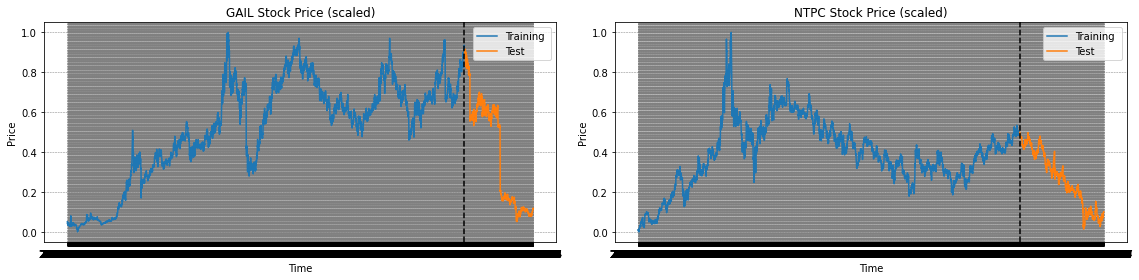

In [67]:
import matplotlib.pyplot as plt

stock_data = {
    'GAIL': (gail_data[0], train_gail_scaled, test_gail_scaled),  # gail_data[0] contains dates for GAIL
    'NTPC': (ntpc_data[0], train_ntpc_scaled, test_ntpc_scaled)   # ntpc_data[0] contains dates for NTPC
}

# Create a figure with two subplots side by side (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

for idx, (name, (time, train, test)) in enumerate(stock_data.items()):
    plt.subplot(1, 2, idx+1)

    idx_2018 = numpy.where(time == '2018-01-01')[0][0]

    # Plot the training data on the left side
    plt.plot(time[:idx_2018+1], train , label='Training ')

    # Plot the test data on the right side
    plt.plot(time[idx_2018+1:], test, label='Test')

    # Add a vertical line at 2018-01-01 for reference
    plt.axvline(time[idx_2018], color='black', ls='--')

    # Set labels and title for the subplot
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(name + ' Stock Price (scaled)')

    # Display legend for the plotted lines
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

plt.tight_layout()
plt.show()

### Task 5: Sequences

Convert the stock prices into sequences based on the specified sequence length $S$:

1. Start the sequence from the initial time step 0.
2. Each sequence includes the number of $S$ prices.
3. The target for each sequence should be the price at the following time step (after $S$).
4. The function should return two tensors: $X$ for the input sequences and $T$ for the target price.

In [72]:
def create_sequences_targets(data: torch.Tensor, S):

    # Initialize empty lists to hold the input sequences and the corresponding target values
    X, T = [], []

    # Go through the data to extract sequences based on S
    for i in range(len(data) - S):
        X.append(data[i:i+S])  
        T.append(data[i+S])    

    # Convert lists of sequences and targets into PyTorch tensors
    return torch.stack(X), torch.stack(T)

### Test 2: Check Sequences and Corresponding Targets

Get all sequences and targets for a given data. This test assures that the X and T vectors are as desired.

In [73]:
# get sequence and targets
data = torch.arange(100,143)
S = 5
X,T = create_sequences_targets(data,S)

assert (X.size(0)==len(data)-S) and X.size(1)==S
assert X.size(0) == T.size(0)
assert torch.sum(T)-4693 < 1e-5
assert X[0,0]-100 < 1e-5 and X[-1,-1] - 141 < 1e-5

### Task 6: Dataset and Data Loader

To enable batch processing, the sequence size must be the same for each element in the batch (otherwise it cannot be transformed as one large tensor). Thus, our dataset needs to have a fixed sequence size $S$. An exact value for $S$ can be selected by yourself.

Implement a `Dataset` class derived from `torch.utils.data.Dataset` that provides $\mathbf X^{[n]}$ and $\mathbf T^{[n]}$. Implement three functions:

1. The constructor `__init__(self, data, S)` that takes the `data` (stock prices) and (initial) sequence length $S$. It should create $X$ and $T$ here by utilizing the function in Task 5.
2. The function `__len__(self)` that returns the number of samples in our dataset.
3. Finally, the index function `__getitem__(self, index)` that returns the sequences $\mathbf X^{[n]}$ and $\mathbf T^{[n]}$ for a given `index`.

After implementing the `Dataset`, initialize `DataLoader` for train and test sets of both datasets with batch size of $B=256$. For the test set, you can opt for the largest feasible batch size.

Hint: When iterating through the dataloader, ensure that  $X$ is shaped as $\mathbb R^{B\times S\times D}$.

Note:
* Be careful about `shuffle` parameter for test dataloaders and keep in mind that you should use scaled data.

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, data, S):

    # store the data and targets as required
    ...

  def __getitem__(self, index):
    # return input and target value for the given index
    return ...

  def __len__(self):
    # return the length of this dataset
    return ...

# instantiate dataset and data loader for a reasonable sequence length S
S = ...
gail_train_dataset = Dataset(...)
gail_train_dataloader = ...

gail_test_dataset = ...
gail_test_dataloader = ...

ntpc_train_dataset = ...
ntpc_train_dataloader = ...

ntpc_test_dataset = ...
ntpc_test_dataloader = ...

## Simple LSTM Network Implementation

In this section, we will explain the implementation of a simple LSTM (Long Short-Term Memory) network for sequence processing in PyTorch. This network is designed to process batches of sequences and predict outputs based on the sequence information.

### Task 7: LSTM Network Implementation

Implement an LSTM network derived from `torch.nn.Module` class using `torch.nn.LSTM`, `torch.nn.Linear` and `torch.nn.Dropout` layers.

1. In the constructor, instantiate all required layers for the given values of $D$ (input size), $K$ (hidden size), $O$ (output size).
2. Network structure:
    * One LSTM layer with input size $D$ and hidden size $K$. Please be careful about `batch_first` parameter when you consider the shape of the $X$ $(B\times S\times D)$.
    * Dropout layer with the probability of $0.2$ on the LSTM network output.
    * A Linear layer with the output neurons of $O$.
3. Implement the input processing within the `forward` function of this LSTM network design. 
The `torch.nn.LSTM` layer returns three distinct elements. Refer to the documentation at https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html to understand the behavior of this layer.
Ensure you comprehend how this layer in PyTorch operates before passing the appropriate input from the LSTM layer to the linear layer.

Note:

* $D$ and $O$ should be passed correctly while you can select any suitable number for $K$

In [ ]:
class LSTMModel(torch.nn.Module):
  def __init__(self, D, K, O):
    super(LSTMModel,self).__init__()

    self.lstm = ...
    self.dropout = ...
    self.linear = ...

  def forward(self, x):

    # lstm layer

    # apply dropout to the output of lstm layer
    
    # get correct element of the output of the lstm layer
    Z = self.linear(...)

    return Z

### Task 8: Training Loop

Implement a function for the train loop. It takes network, dataloader, optimizer, loss function, device and the number epochs.

If your dataset function from Task 5 is not fully compatible in terms of the shapes of logits and targets, you can use `squeeze()` or `unsqueeze()` operations to ensure smooth operation of the loss calculation. Alternatively, you may modify your dataset function to address this issue. Both works.

Compute the average training loss per epoch and print it out.

WARNING: Loss function will not complain when the index order for the output $\mathcal Y$ and targets $\mathcal T$ is incorrect, just the results will be wrong.

In [ ]:
def train(network,train_dataloader,optimizer,loss,device,epochs=50):
    ...

    for epoch in range(epochs):

        train_loss = ...
        total_sample = ...

        for x, t in train_dataloader:
            ...


        # print average loss for training and validation
        print(f"\rEpoch {epoch+1}; train loss: {train_loss/total_sample:1.5f}")

### Task 9: Run Training on Both Datasets

* To train the LSTM network, you will decide the loss function when you consider the context of the problem.
* Instantiate the optimizer with an appropriate learning rate $\eta$.
* Implement the training loop for $50$ epochs.
* Run the network on the train sets of both datasets.

Note that 50 epochs will not take long times, if implemented in an optimized way. So you may run on either GPU or CPU.

In [ ]:
device = ...
loss = ...
epochs = ...

# for gail dataset
lstm_gail_network = LSTMModel(...)
optimizer_gail = ...
train(...)

In [ ]:
# for ntpc dataset, initialize the network again with the same D,K and O
lstm_ntpc_network = LSTMModel(...)
optimizer_ntpc = ...
train(...)

### Task 10: Future Price Prediction

Write a function that predicts the next price of the sequence (test set) based on the values obtained from the network.

This function executes the trained model on the test datasets from both datasets. It takes the trained model and the test data loader.

Keep in mind that all predictions are also normalized, as the input data is normalized. These normalized predictions should be reversed to the original scale for visualization in the next task.

In [ ]:
def predict(network,test_dataloader):
  predictions = ...

  ...

  return predictions

# run the test for both datasets
scaled_lstm_gail_preds = predict(...)
scaled_lstm_ntpc_preds = predict(...)

# reverse the test input and its predictions to original scales
# reverse its predictions to original scales
original_lstm_gail_preds = ...
original_lstm_ntpc_preds = ...

### Task 11: Plotting Future Predictions

Plot the actual prices and model predictions for only both test datasets.

In [ ]:
import matplotlib.pyplot as plt

future_preds = {
    'GAIL': (gail_test[S:], original_lstm_gail_preds),
    'NTPC': (ntpc_test[S:], original_lstm_ntpc_preds)
}

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

for idx, (..., (..., ...)) in enumerate(future_preds.items()):
    # Plot on the corresponding subplot (idx+1) within the 1x2 grid
    plt.subplot(1, 2, idx+1)

    # Plot the training data on the left side of the split subplot
    plt.plot(..., label='Actual Price')

    # Plot the test data on the right side of the split subplot
    plt.plot(..., label='Model Prediction')

    # Set labels and title for the subplot
    plt.xlabel('Time (days)')
    plt.ylabel('Price')
    plt.title(...)

    # Display legend for the plotted lines
    plt.legend()

    # Add gridlines with specified style, width, and color
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

plt.tight_layout()
plt.show()